In [1]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from facenet_pytorch import MTCNN, InceptionResnetV1, training

import yaml
from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

from functions import load_data, plot_from_batch_generator
from netrunner import CNNetRunner

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print('Running on device: {}'.format(device))

Running on device: cuda


In [2]:
config = yaml.safe_load(open('config.yaml'))

Будем использовать библиотеку facenet, в которую входит детектор лица MTCNN и классификатор InceptionResnetV1, предобученные для распознования лиц.

In [ ]:
# вырезаем лица
mtcnn = MTCNN(
        image_size=config['CROP_OUTPUT_SIZE'], margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=device
    )
    
dataset = torchvision.datasets.ImageFolder(data_dir, 
                                           transform=transforms.Resize((512, 512)))
dataset.samples = [
        (p, p.replace(data_dir, data_dir + '_cropped'))
            for p, _ in dataset.samples
        ]
loader = torch.utils.data.DataLoader(
        dataset,
        num_workers=config['NUM_WORKERS'],
        batch_size=config['CROP_BATCH_SIZE'],
        collate_fn=training.collate_pil
        )
for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
# Remove mtcnn to reduce GPU memory usage
del mtcnn

In [4]:
transformer = transforms.Compose([        
    transforms.ToTensor(),                      
    transforms.Normalize(config['image_mean'], config['image_std'])
])

In [5]:
train_batch, val_batch = load_data(config['DATA_PATH']+'_cropped', transformer)

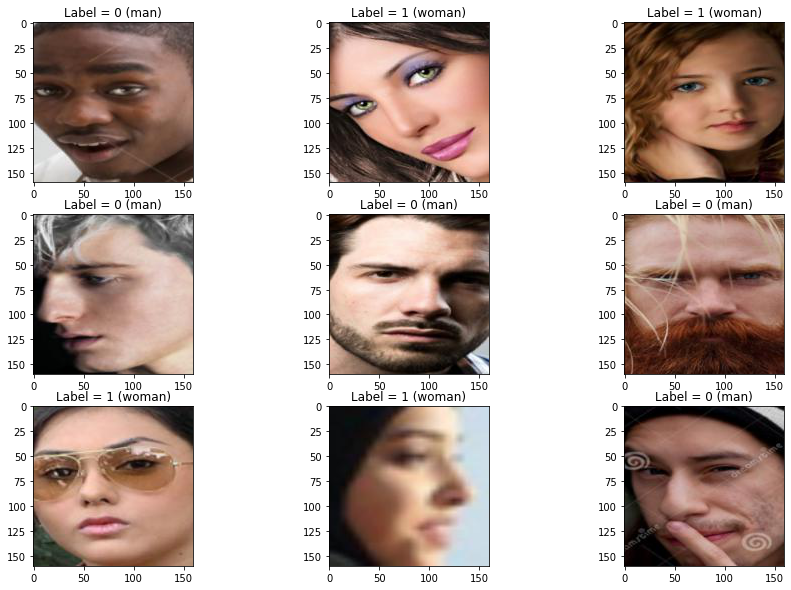

In [9]:
plot_from_batch_generator(train_batch)

## Create model

In [6]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=2
)

Обучим последний fc-слой

In [9]:
list(resnet.children())[-5:]

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=2, bias=True)]

In [7]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.ft_model = nn.Sequential(*list(resnet.children())[:-4])
        for p in self.ft_model.parameters():
            p.requires_grad = False
        self.dropout = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.6, inplace=False)
        )
        self.fc = nn.Sequential(
            nn.Linear(1792, 512, bias=False),
            nn.BatchNorm1d(512)
        )
        self.pred = nn.Sequential(
            nn.Linear(512, 2, bias=True)
        )

    def forward(self, x):
        with torch.no_grad():
            x = self.ft_model(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.pred(x)
        return x

In [8]:
model = MyModel()

In [ ]:
summary(model, (3, 160, 160), device='cpu')

In [9]:
# проверим какой score дает предобученная сеть без fine tuning'а
resnet.to(device)
cnn = CNNetRunner(resnet, device)
cnn.validate(val_batch, resnet)

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

/home/lonelits/anaconda3/envs/severstal_cv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


val: loss: 0.7877 | accuracy: 0.4767 | f1_score: 0.4993


{'loss': 0.7877465,
 'accuracy': 0.47671840354767187,
 'f1_score': 0.49929278642149927}

Из коробки получается точность 0.47, что очень плохо.  
  
Дообучим нейросеть.

In [10]:
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
ckpt_name='model_faces.ckpt'
cnn = CNNetRunner(model, device, opt, checkpoint_name=ckpt_name)

val: loss: 0.2389 | accuracy: 0.9143 | f1_score: 0.9199


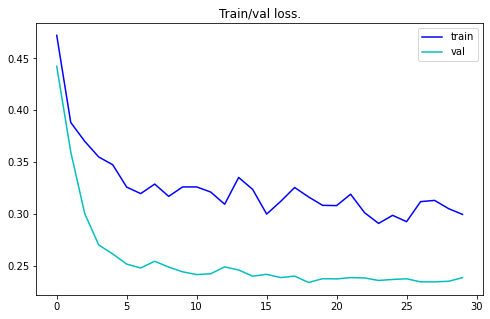

In [11]:
cnn.train(train_batch, val_batch, n_epochs=config['EPOCH_NUM'], visualize=True)

In [12]:
best_model = None
with open('model_faces.ckpt', 'rb') as f:
    best_model = torch.load(f)

In [13]:
cnn = CNNetRunner(best_model, device)
cnn.validate(val_batch, best_model)

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

val: loss: 0.2362 | accuracy: 0.9180 | f1_score: 0.9241


{'loss': 0.23619454,
 'accuracy': 0.917960088691796,
 'f1_score': 0.9241285030758716}

Результат получился кратно лучше, с этим можно работать.